# MACD Calculator

## Weekly MACD Trading Strategy

[*********************100%%**********************]  1 of 1 completed


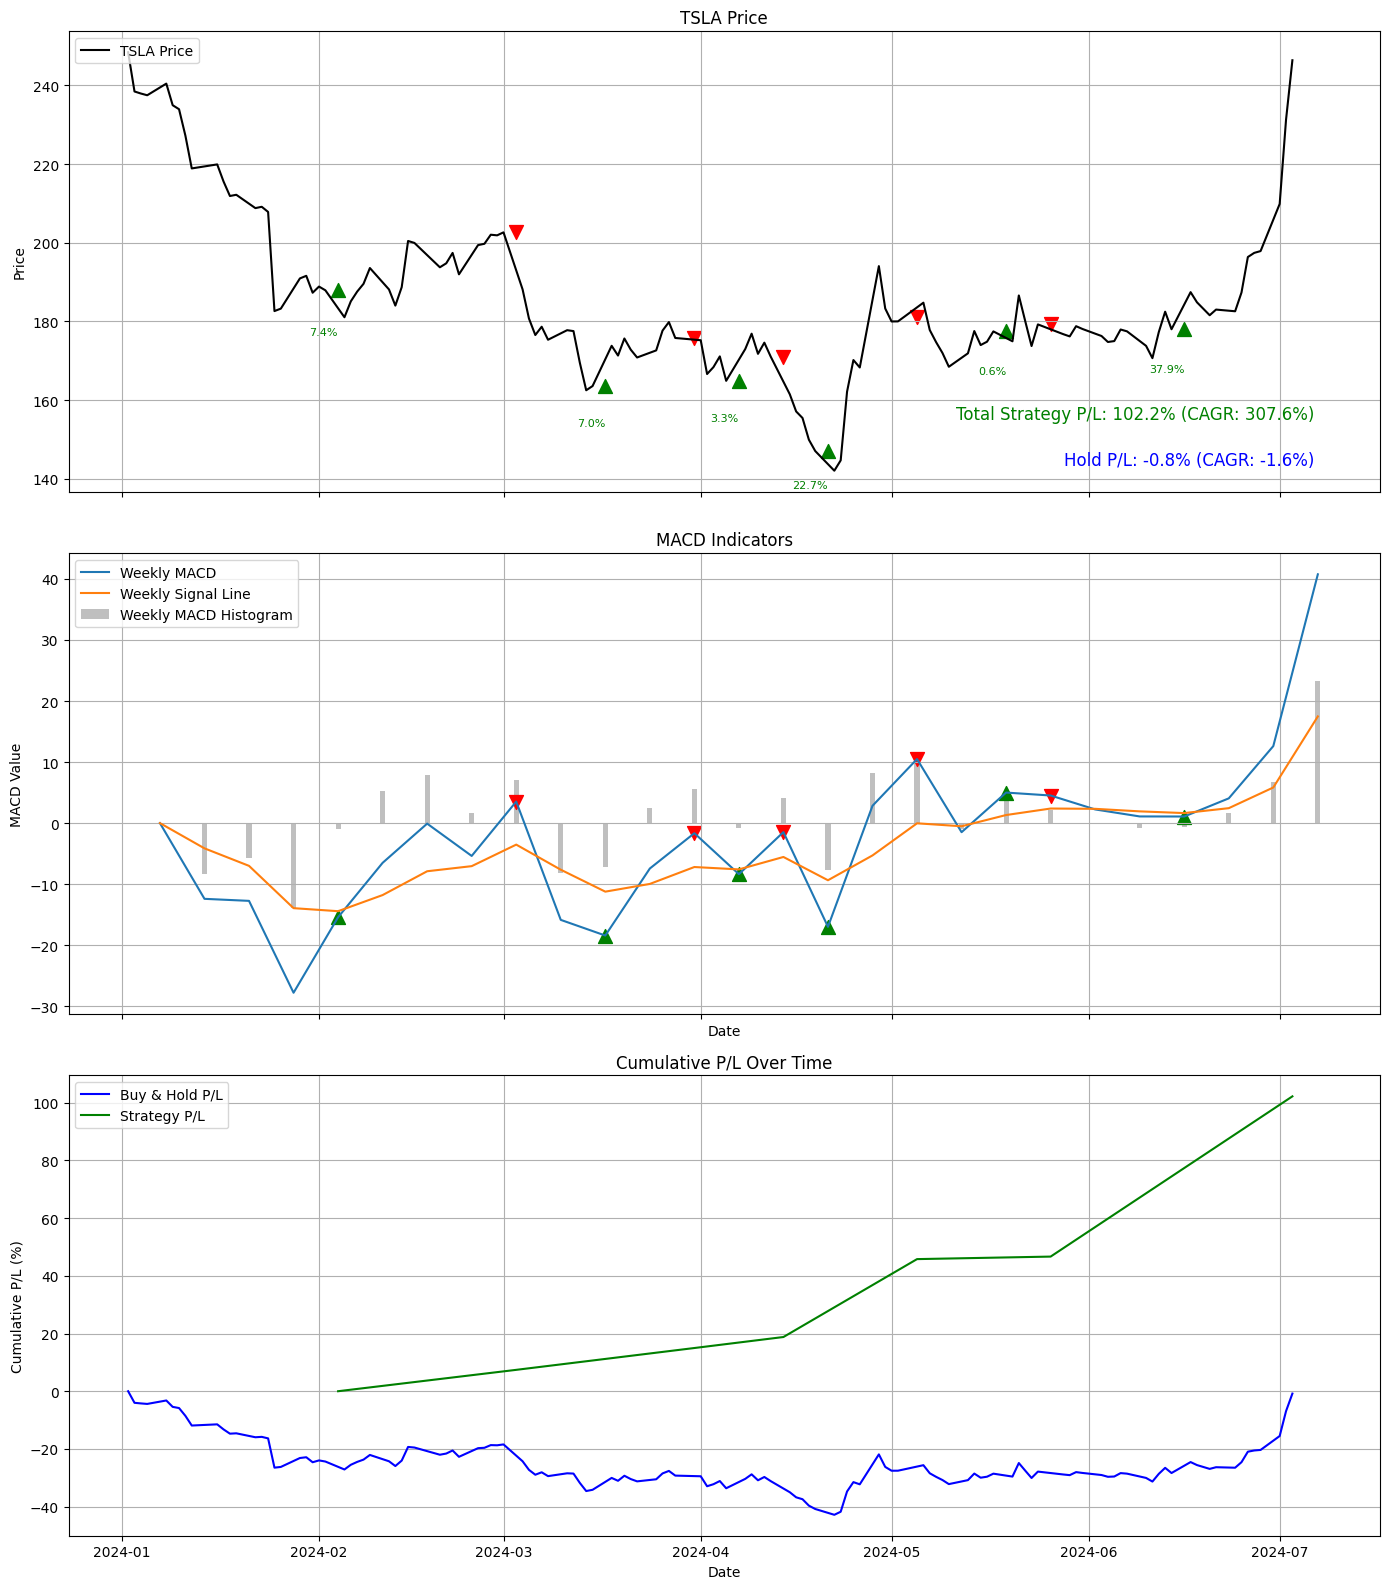

Total Invested: £14,333.33
Total Worth: £21,020.02
Total Profit: £6,686.69
    Buy Date  Sell Date   Buy Price  Sell Price  Profit/Loss (%)
0 2024-02-04 2024-03-03  188.285824  202.234719         7.408362
1 2024-03-17 2024-03-31  163.897147  175.438413         7.041774
2 2024-04-07 2024-04-14  165.229794  170.707903         3.315449
3 2024-04-21 2024-05-05  147.344103  180.827622        22.724709
4 2024-05-19 2024-05-26  177.814927  178.881525         0.599836
5 2024-06-16 2024-07-03  178.366014  245.897219        37.861027


In [413]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

def calculate_macd(df, short_window=1, long_window=5, signal_window=5):
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_gradients(df):
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    return df

def find_turning_points(df):
    turning_points_buy = []
    turning_points_sell = []
    
    for i in range(1, len(df)-1):
        if df['MACD_Gradient'].iloc[i-1] < 0 and df['MACD_Gradient'].iloc[i] >= 0:
            turning_points_buy.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
        if df['MACD_Gradient'].iloc[i-1] > 0 and df['MACD_Gradient'].iloc[i] <= 0:
            turning_points_sell.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
    
    return turning_points_buy, turning_points_sell

def filter_signals(buy_signals, sell_signals, df):
    filtered_buy_signals = []
    filtered_sell_signals = []
    last_sell_date = None
    
    for buy_signal in buy_signals:
        if last_sell_date is None or buy_signal[0] > last_sell_date:
            filtered_buy_signals.append(buy_signal)
            corresponding_sell_signal = next((sell_signal for sell_signal in sell_signals if sell_signal[0] > buy_signal[0]), None)
            if corresponding_sell_signal:
                filtered_sell_signals.append(corresponding_sell_signal)
                last_sell_date = corresponding_sell_signal[0]
    
    return filtered_buy_signals, filtered_sell_signals

def calculate_profit_loss(buy_signals, sell_signals, df_price, transaction_fee=0.002):
    profit_loss = []
    cumulative_pl = []
    capital = 100  # Starting capital (arbitrary value for percentage calculation)
    trade_dates = []
    trade_records = []  # To store trade details

    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1] * (1 + transaction_fee)
        if i < len(sell_signals):
            sell_price = sell_signals[i][1] * (1 - transaction_fee)
            sell_date = sell_signals[i][0]
        else:
            sell_price = df_price['Close'].iloc[-1] * (1 - transaction_fee)
            sell_date = df_price.index[-1]
        pl = (sell_price - buy_price) / buy_price * 100
        capital *= (1 + pl / 100)
        profit_loss.append(pl)
        cumulative_pl.append(capital - 100)
        trade_dates.append((buy_signals[i][0], sell_date))
        trade_records.append({
            'Buy Date': buy_signals[i][0],
            'Sell Date': sell_date,
            'Buy Price': buy_price,
            'Sell Price': sell_price,
            'Profit/Loss (%)': pl
        })
    
    start_price = df_price['Close'].iloc[0]
    end_price = df_price['Close'].iloc[-1]
    hold_pl = (end_price - start_price) / start_price * 100
    
    return profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records

def calculate_cagr(start_value, end_value, start_date, end_date):
    years = (end_date - start_date).days / 365.25
    cagr = (end_value / start_value) ** (1 / years) - 1
    return cagr * 100

def calculate_cumulative_contribution(cumulative_pl, trade_dates, initial_capital=6000, yearly_contribution=20000):
    capital = initial_capital
    total_invested = initial_capital
    total_value = []
    
    # Generate monthly contribution dates
    start_date = trade_dates[0][0]
    end_date = trade_dates[-1][1]
    contribution_dates = pd.date_range(start=start_date, end=end_date, freq='M')

    for date in contribution_dates:
        capital += yearly_contribution / 12  # Monthly contribution
        total_invested += yearly_contribution / 12
        if date >= trade_dates[0][0]:
            for i in range(len(trade_dates)):
                if date <= trade_dates[i][1]:
                    break
            total_value.append(capital * (1 + cumulative_pl[i] / 100))
        else:
            total_value.append(capital)
    
    return total_value[-1], total_invested

def plot_price_macd(df_price, df_weekly, buy_signals, sell_signals, profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16), sharex=True)
    
    ax1.plot(df_price.index, df_price['Close'], label=f'{ticker} Price', color='black')
    ax1.set_title(f'{ticker} Price')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    for date, price, macd_value in buy_signals:
        ax1.scatter(date, price, color='green', marker='^', s=100, label='Buy Signal')
    for date, price, macd_value in sell_signals:
        ax1.scatter(date, price, color='red', marker='v', s=100, label='Sell Signal')
    
    for i, pl in enumerate(profit_loss):
        ax1.text(buy_signals[i][0], buy_signals[i][1] * 0.95, f'{pl:.1f}%', fontsize=8, color='green', ha='right', va='top')
    
    total_strategy_pl = cumulative_pl[-1] if cumulative_pl else 0
    strategy_cagr = calculate_cagr(100, total_strategy_pl + 100, df_price.index[0], df_price.index[-1])
    hold_cagr = calculate_cagr(df_price['Close'].iloc[0], df_price['Close'].iloc[-1], df_price.index[0], df_price.index[-1])
    
    ax1.text(0.95, 0.05, f'Hold P/L: {hold_pl:.1f}% (CAGR: {hold_cagr:.1f}%)', transform=ax1.transAxes, fontsize=12, color='blue', ha='right', va='bottom')
    ax1.text(0.95, 0.15, f'Total Strategy P/L: {total_strategy_pl:.1f}% (CAGR: {strategy_cagr:.1f}%)', transform=ax1.transAxes, fontsize=12, color='green', ha='right', va='bottom')

    ax2.plot(df_weekly.index, df_weekly['MACD'], label='Weekly MACD', color='tab:blue', linewidth=1.5)
    ax2.plot(df_weekly.index, df_weekly['Signal_Line'], label='Weekly Signal Line', color='tab:orange', linestyle='-', linewidth=1.5)
    ax2.bar(df_weekly.index, df_weekly['MACD'] - df_weekly['Signal_Line'], label='Weekly MACD Histogram', color='grey', alpha=0.5)
    
    for date, price, macd_value in buy_signals:
        ax2.scatter(date, macd_value, color='green', marker='^', s=100)
    for date, price, macd_value in sell_signals:
        ax2.scatter(date, macd_value, color='red', marker='v', s=100)
    
    ax2.set_title('MACD Indicators')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD Value')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    ax3.plot(df_price.index, (df_price['Close'] / df_price['Close'].iloc[0] - 1) * 100, label='Buy & Hold P/L', color='blue')
    strategy_dates = [trade[1] for trade in trade_dates]
    strategy_dates.insert(0, trade_dates[0][0])
    cumulative_pl.insert(0, 0)
    ax3.plot(strategy_dates, cumulative_pl, label='Strategy P/L', color='green')
    ax3.set_title('Cumulative P/L Over Time')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative P/L (%)')
    ax3.legend(loc='upper left')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate cumulative contribution value
    total_value, total_invested = calculate_cumulative_contribution(cumulative_pl, trade_dates)
    total_profit = total_value - total_invested
    
    print(f"Total Invested: £{total_invested:,.2f}")
    print(f"Total Worth: £{total_value:,.2f}")
    print(f"Total Profit: £{total_profit:,.2f}")

    # Display the trade table
    trade_df = pd.DataFrame(trade_records)
    print(trade_df)

if __name__ == "__main__":
    ticker = 'TSLA'
    start_date = '2024-01-01'
    end_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')
    df = yf.download(ticker, start=start_date, end=end_date)
    
    df_weekly = df.resample('W').last()
    df_weekly = calculate_macd(df_weekly)
    df_weekly = calculate_gradients(df_weekly)
    
    buy_signals, sell_signals = find_turning_points(df_weekly)
    filtered_buy_signals, filtered_sell_signals = filter_signals(buy_signals, sell_signals, df)
    
    profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records = calculate_profit_loss(filtered_buy_signals, filtered_sell_signals, df)
    
    plot_price_macd(df, df_weekly, filtered_buy_signals, filtered_sell_signals, profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records)

## Walk-Forward Analysis

[*********************100%%**********************]  1 of 1 completed


     Buy Date  Sell Date   Buy Price  Sell Price  Profit/Loss (%)
0  2020-03-30 2020-04-27   34.085369   49.075652        43.978645
1  2020-05-04 2020-05-18   46.826800   55.074963        17.614192
2  2020-05-26 2020-06-22   55.744598   66.530003        19.347894
3  2020-06-29 2020-07-20   64.729871  101.064799        56.133169
4  2020-08-10 2020-08-31   96.726399  147.906932        52.912682
5  2020-09-14 2020-09-28  127.237296  141.256913        11.018481
6  2020-10-05 2020-10-19  141.398902  148.449180         4.986091
7  2020-11-09 2020-12-07  146.793000  201.236719        37.088771
8  2020-12-14 2020-12-28  206.745995  224.386997         8.532693
9  2020-08-03 2020-08-31   96.806561  147.906932        52.786061
10 2020-09-14 2020-09-28  127.237296  141.256913        11.018481
11 2020-10-05 2020-10-19  141.398902  148.449180         4.986091
12 2020-11-02 2020-12-07  131.595995  201.236719        52.920094
13 2020-12-14 2020-12-28  206.745995  224.386997         8.532693
14 2021-01

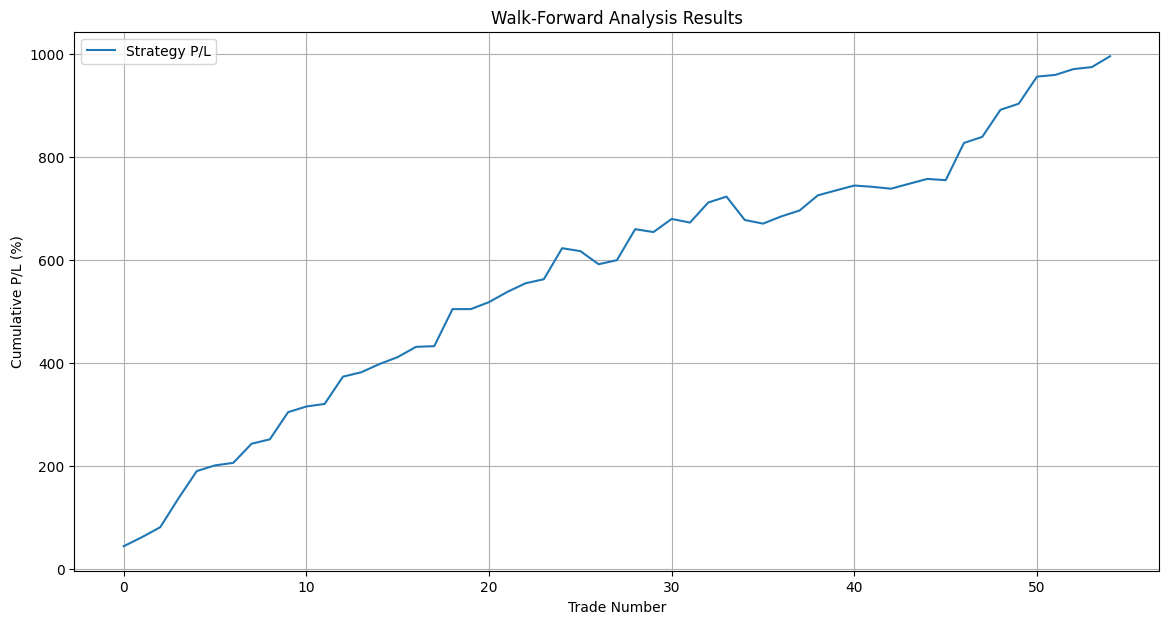

In [939]:
def calculate_macd(df, short_window=1, long_window=35, signal_window=5):
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

def calculate_gradients(df):
    df['MACD_Gradient'] = np.gradient(df['MACD'])
    return df

def find_turning_points(df):
    turning_points_buy = []
    turning_points_sell = []
    
    for i in range(1, len(df)-1):
        if df['MACD_Gradient'].iloc[i-1] < 0 and df['MACD_Gradient'].iloc[i] >= 0:
            turning_points_buy.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
        if df['MACD_Gradient'].iloc[i-1] > 0 and df['MACD_Gradient'].iloc[i] <= 0:
            turning_points_sell.append((df.index[i], df['Close'].iloc[i], df['MACD'].iloc[i]))
    
    return turning_points_buy, turning_points_sell

def find_next_trading_day(date, df):
    next_day = date + timedelta(days=1)
    while next_day not in df.index:
        next_day += timedelta(days=1)
    return next_day

def filter_signals(buy_signals, sell_signals, df):
    filtered_buy_signals = []
    filtered_sell_signals = []
    last_sell_date = None
    
    for buy_signal in buy_signals:
        next_buy_date = find_next_trading_day(buy_signal[0], df)
        if last_sell_date is None or next_buy_date > last_sell_date:
            filtered_buy_signals.append((next_buy_date, df.loc[next_buy_date, 'Open'], buy_signal[2]))
            corresponding_sell_signal = next((sell_signal for sell_signal in sell_signals if find_next_trading_day(sell_signal[0], df) > next_buy_date), None)
            if corresponding_sell_signal:
                next_sell_date = find_next_trading_day(corresponding_sell_signal[0], df)
                filtered_sell_signals.append((next_sell_date, df.loc[next_sell_date, 'Open'], corresponding_sell_signal[2]))
                last_sell_date = next_sell_date
    
    return filtered_buy_signals, filtered_sell_signals

def calculate_profit_loss(buy_signals, sell_signals, df_price, transaction_fee=0.002):
    profit_loss = []
    cumulative_pl = []
    capital = 100  # Starting capital (arbitrary value for percentage calculation)
    trade_dates = []
    trade_records = []  # To store trade details

    for i in range(len(buy_signals)):
        buy_price = buy_signals[i][1] * (1 + transaction_fee)
        if i < len(sell_signals):
            sell_price = sell_signals[i][1] * (1 - transaction_fee)
            sell_date = sell_signals[i][0]
        else:
            sell_price = df_price['Close'].iloc[-1] * (1 - transaction_fee)
            sell_date = df_price.index[-1]
        pl = (sell_price - buy_price) / buy_price * 100
        capital *= (1 + pl / 100)
        profit_loss.append(pl)
        cumulative_pl.append(capital - 100)
        trade_dates.append((buy_signals[i][0], sell_date))
        trade_records.append({
            'Buy Date': buy_signals[i][0],
            'Sell Date': sell_date,
            'Buy Price': buy_price,
            'Sell Price': sell_price,
            'Profit/Loss (%)': pl
        })
    
    start_price = df_price['Close'].iloc[0]
    end_price = df_price['Close'].iloc[-1]
    hold_pl = (end_price - start_price) / start_price * 100
    
    return profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records

def walk_forward_analysis(ticker, start_date, end_date, window_size, step_size):
    df = yf.download(ticker, start=start_date, end=end_date)
    df_weekly = df.resample('W').last()
    
    all_trade_records = []
    all_profit_loss = []
    
    current_start = start_date
    while current_start + window_size + step_size <= end_date:
        in_sample_end = current_start + window_size
        out_of_sample_end = in_sample_end + step_size
        
        in_sample_data = df.loc[current_start:in_sample_end]
        out_of_sample_data = df.loc[in_sample_end:out_of_sample_end]
        
        df_weekly_in_sample = in_sample_data.resample('W').last()
        df_weekly_out_of_sample = out_of_sample_data.resample('W').last()
        
        df_weekly_in_sample = calculate_macd(df_weekly_in_sample)
        df_weekly_in_sample = calculate_gradients(df_weekly_in_sample)
        
        buy_signals, sell_signals = find_turning_points(df_weekly_in_sample)
        filtered_buy_signals, filtered_sell_signals = filter_signals(buy_signals, sell_signals, df)
        
        profit_loss, hold_pl, cumulative_pl, trade_dates, trade_records = calculate_profit_loss(filtered_buy_signals, filtered_sell_signals, out_of_sample_data)
        
        all_trade_records.extend(trade_records)
        all_profit_loss.extend(profit_loss)
        
        current_start += step_size
    
    return all_trade_records, all_profit_loss

def plot_walk_forward_results(all_trade_records, all_profit_loss):
    trade_df = pd.DataFrame(all_trade_records)
    print(trade_df)
    
    plt.figure(figsize=(14, 7))
    plt.plot(np.cumsum(all_profit_loss), label='Strategy P/L')
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative P/L (%)')
    plt.title('Walk-Forward Analysis Results')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    ticker = 'TSLA'
    start_date = pd.Timestamp('2020-01-01')
    end_date = datetime.today()
    window_size = pd.DateOffset(years=1)
    step_size = pd.DateOffset(months=6)
    
    all_trade_records, all_profit_loss = walk_forward_analysis(ticker, start_date, end_date, window_size, step_size)
    plot_walk_forward_results(all_trade_records, all_profit_loss)